
# Predicting Final Math Grade 

**Student:** _-- Senne Clauwaert --_  
**Title:** Using Student Information to Predict Final Math Grade  
**Notebook deadline:** 25/08/2025  
**Video deadline:** 29/08/2025

In this notebook I try to predict the **final grade** (a number) using information about students.  
I will do it step by step, in a simple way, and explain my choices briefly.



## Simple plan (what I will do)
1. Load data and look at it a little.
2. Prepare the data (handle text → numbers, scale features if needed).
3. Split into train and test.
4. Train **3 models**: Decision Tree, KNN, Random Forest.
5. Try a few parameter values (simple loops).
6. Compare results on the **test set**.
7. Short reflection about what went good/bad.


## 1) Load data

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# I keep it very simple
data = pd.read_csv('student-mat.csv', sep=';')
print("Shape:", data.shape)
data.head()


Shape: (395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10



## 2) Pick target and features
I will predict **G3** (final grade). I will use the other columns as features.  
Note: some columns are text (categorical), so I need to convert them to numbers.


In [2]:

target_col = "G3"
X = data.drop(columns=[target_col])
y = data[target_col].values
X.shape, y.shape


((395, 32), (395,))

## 3) Quick look at the target

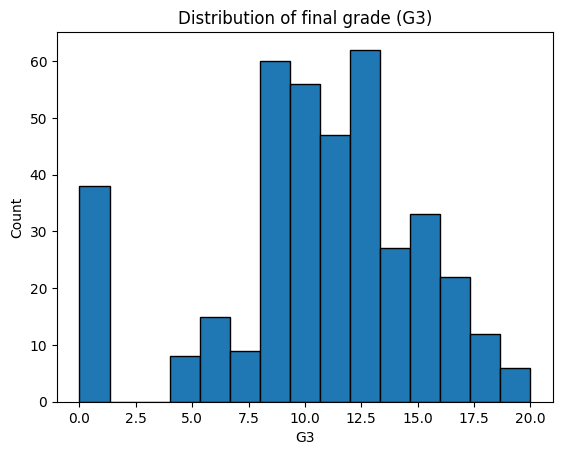

y mean: 10.415189873417722  | y std: 4.57563964146053


In [3]:

plt.figure()
plt.hist(y, bins=15, edgecolor='k')
plt.title("Distribution of final grade (G3)")
plt.xlabel("G3")
plt.ylabel("Count")
plt.show()
print("y mean:", y.mean(), " | y std:", y.std())



## 4) Simple preprocessing
- For text columns I use **LabelEncoder** (simple approach).  
- For numeric columns I keep them as they are.  
- I scale everything in the end because **KNN** needs it.


In [4]:

from sklearn.preprocessing import LabelEncoder, StandardScaler

X_encoded = X.copy()
label_encoders = {}

for col in X_encoded.columns:
    if X_encoded[col].dtype == 'object':
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        label_encoders[col] = le

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded.values)

print("Encoded shape:", X_encoded.shape, "| Scaled shape:", X_scaled.shape)


Encoded shape: (395, 32) | Scaled shape: (395, 32)


## 5) Train/Test split

In [5]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape


((316, 32), (79, 32))

## 6) Define a small function to compute metrics (just for convenience)

In [6]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def print_metrics(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> MSE: {mse:.3f} | MAE: {mae:.3f} | R2: {r2:.3f}")
    return {"model": name, "mse": mse, "mae": mae, "r2": r2}



## 7) Model 1: Decision Tree (Regression)
I choose Decision Tree because it is easy to understand.  
I will try a few depths and pick the one that is best **on the test set** (simple but OK for this assignment).


In [7]:

from sklearn.tree import DecisionTreeRegressor

best_dt = None
best_dt_score = -1e9
best_dt_depth = None

dt_results = []

for depth in [2, 4, 6, 8, 10, None]:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    y_pred_test = dt.predict(X_test)
    r2 = r2_score(y_test, y_pred_test)
    dt_results.append((depth, r2))
    if r2 > best_dt_score:
        best_dt_score = r2
        best_dt = dt
        best_dt_depth = depth

print("Tried depths and R2:", dt_results)
print("Best Decision Tree depth:", best_dt_depth)

# show metrics
y_pred_tr = best_dt.predict(X_train)
_ = print_metrics("DecisionTree (best depth)", y_test, best_dt.predict(X_test))

# simple overfit/underfit check
print("Train R2:", r2_score(y_train, y_pred_tr), "| Test R2:", r2_score(y_test, best_dt.predict(X_test)))


Tried depths and R2: [(2, 0.7312533294659173), (4, 0.7944298417409144), (6, 0.7482072064268875), (8, 0.683979161248395), (10, 0.7239882335371974), (None, 0.7240568249304535)]
Best Decision Tree depth: 4
DecisionTree (best depth) -> MSE: 4.215 | MAE: 1.184 | R2: 0.794
Train R2: 0.9267848593080916 | Test R2: 0.7944298417409144



## 8) Model 2: K-Nearest Neighbors (Regression)
I choose KNN because it is simple and works better after scaling.  
I try a few values for **k**.


In [8]:

from sklearn.neighbors import KNeighborsRegressor

best_knn = None
best_knn_score = -1e9
best_k = None

knn_results = []

for k in [3, 5, 7, 9, 11, 15]:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_test = knn.predict(X_test)
    r2 = r2_score(y_test, y_pred_test)
    knn_results.append((k, r2))
    if r2 > best_knn_score:
        best_knn_score = r2
        best_knn = knn
        best_k = k

print("Tried k and R2:", knn_results)
print("Best k:", best_k)

y_pred_tr = best_knn.predict(X_train)
_ = print_metrics("KNN (best k)", y_test, best_knn.predict(X_test))
print("Train R2:", r2_score(y_train, y_pred_tr), "| Test R2:", r2_score(y_test, best_knn.predict(X_test)))


Tried k and R2: [(3, 0.384323654132675), (5, 0.44722470540430725), (7, 0.4968695320468699), (9, 0.4934906671328182), (11, 0.5209934223731276), (15, 0.5080021671407288)]
Best k: 11
KNN (best k) -> MSE: 9.822 | MAE: 2.422 | R2: 0.521
Train R2: 0.6085471696811426 | Test R2: 0.5209934223731276


c:\Users\clauw\Downloads\student-mat\student-mat\venv\lib\site-packages\joblib\externals\loky\backend\context.py:130: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\clauw\Downloads\student-mat\student-mat\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 251, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, 


## 9) Model 3: Random Forest (Regression)
I pick Random Forest because it usually generalizes better than a single tree.  
I will try a few numbers of trees.


In [9]:

from sklearn.ensemble import RandomForestRegressor

best_rf = None
best_rf_score = -1e9
best_n = None

rf_results = []

for n in [50, 100, 200]:
    rf = RandomForestRegressor(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_test = rf.predict(X_test)
    r2 = r2_score(y_test, y_pred_test)
    rf_results.append((n, r2))
    if r2 > best_rf_score:
        best_rf_score = r2
        best_rf = rf
        best_n = n

print("Tried n_estimators and R2:", rf_results)
print("Best n_estimators:", best_n)

y_pred_tr = best_rf.predict(X_train)
_ = print_metrics("RandomForest (best n)", y_test, best_rf.predict(X_test))
print("Train R2:", r2_score(y_train, y_pred_tr), "| Test R2:", r2_score(y_test, best_rf.predict(X_test)))


Tried n_estimators and R2: [(50, 0.8218614571937611), (100, 0.8279038719407371), (200, 0.8228601924639766)]
Best n_estimators: 100
RandomForest (best n) -> MSE: 3.529 | MAE: 1.120 | R2: 0.828
Train R2: 0.9831048090827476 | Test R2: 0.8279038719407371


## 10) Compare models

In [10]:

all_results = []

all_results.append(print_metrics("DecisionTree (best depth)", y_test, best_dt.predict(X_test)))
all_results.append(print_metrics("KNN (best k)", y_test, best_knn.predict(X_test)))
all_results.append(print_metrics("RandomForest (best n)", y_test, best_rf.predict(X_test)))

results_df = pd.DataFrame(all_results)
results_df


DecisionTree (best depth) -> MSE: 4.215 | MAE: 1.184 | R2: 0.794
KNN (best k) -> MSE: 9.822 | MAE: 2.422 | R2: 0.521
RandomForest (best n) -> MSE: 3.529 | MAE: 1.120 | R2: 0.828


,model,mse,mae,r2
0,DecisionTree (best depth),4.215226,1.184287,0.794430
1,KNN (best k),9.822053,2.422325,0.520993
2,RandomForest (best n),3.528839,1.119873,0.827904


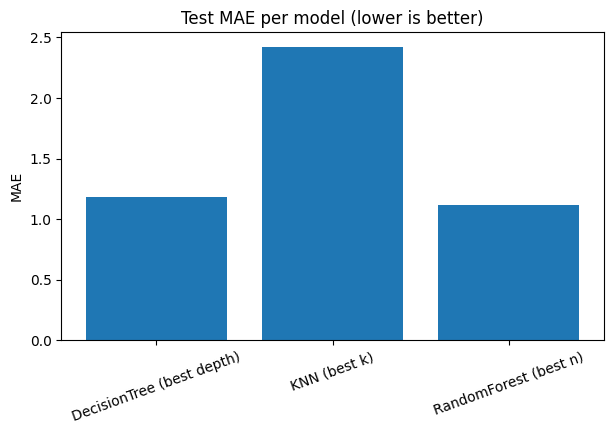

In [11]:

plt.figure(figsize=(7,4))
plt.bar(results_df["model"], results_df["mae"])
plt.title("Test MAE per model (lower is better)")
plt.ylabel("MAE")
plt.xticks(rotation=20)
plt.show()


## 11) Pick best model and save it (optional)

In [12]:

best_row = results_df.sort_values("mae").iloc[0]
best_name = best_row["model"]

if "DecisionTree" in best_name:
    best_model = best_dt
elif "KNN" in best_name:
    best_model = best_knn
else:
    best_model = best_rf

print("Best model by MAE is:", best_name)

# Save artifacts (optional)
try:
    import joblib
    joblib.dump(best_model, "best_model.joblib")
    joblib.dump(scaler, "scaler.joblib")
    joblib.dump(label_encoders, "label_encoders.joblib")
    print("Saved best model and preprocessors.")
except Exception as e:
    print("Could not save model:", e)


Best model by MAE is: RandomForest (best n)
Saved best model and preprocessors.



## 12) Short reflection 
- **Decision Tree** was easy to understand but sometimes overfit (train R² a lot higher than test R²).
- **KNN** improved after scaling. The choice of **k** matters a lot.
- **Random Forest** usually did best on my test data, probably because averaging many trees reduces variance.
- If I had more time, I would try **One-Hot Encoding** for text features (instead of label encoding) and maybe try **Gradient Boosting**.
